In [252]:
import pandas as pd 
import linearmodels
import statsmodels.api
import collections
import matplotlib.pyplot as plt
import csv

Importing the data and creating the lags

In [253]:
df = pd.read_csv('C:\\Users\\Algica\\Documents\\Msc 3\\1. Corporate finance\\Homework 1\\19quaq6b5hmd0qmi.csv',parse_dates=['fyear'])
df = df.sort_values(by=['conm','datadate'])
df = df.set_index(['conm'])
df['lprice'] = df['prcc_f'].groupby(level="conm").shift(1)
df['lat'] = df['at'].groupby(level="conm").shift(1)

#keeping fiscal years 1995-2015
df = df[(df['fyear'] >= '1995') & (df['fyear'] <= '2015')]
#add fiscal year 1995!

Creation of the financial ratios

In [254]:
df['Book_leverage1'] = (df['dlc']+df['dltt'])/df['at']
df['Book_leverage2'] = df['lt']/df['at']
df['Market_value_of_equity'] = df['csho']*df['prcc_f']
df['Market_leverage'] = (df['dlc']+df['dltt'])/(df['dlc']+df['dltt']+df['pstk']+(df['csho']*df['prcc_f']))
df['Market_to_book'] = ((df['prcc_f']*df['csho'])+df['dltt']+df['dlc']+df['pstkl']-df['txditc'])/df['at']
df['Asset_growth'] = df['at']/df['lat']-1
df['Asset_tangibility'] = df['ppent']/df['at']
df['Return_on_equity'] = df['ni']/df['ceq']
df['Profit_margin'] = df['ni']/df['sale']
df['CAPEX_ratio'] = df['capx']/df['at']
df['Dividend_yield'] = (df['dv']/df['csho'])/(df['lprice']/df['csho'])
df['Dividend_payout_ratio'] = df['dv']/df['ni']
df['Total_payout_ratio'] = (df['dv']+df['prstkc'])/df['ni']
df['EBIT_interest_coverage'] = df['ebit']/df['xint']
df['Cash_holdings'] = df['che']/df['at']
df['Profitability'] = df['oibdp']/df['at']
ratios = ['Book_leverage1','Book_leverage2','Market_value_of_equity','Market_leverage','Market_to_book','Asset_growth','Asset_tangibility','Return_on_equity','Profit_margin','CAPEX_ratio','Dividend_yield','Dividend_payout_ratio','Total_payout_ratio','EBIT_interest_coverage','Cash_holdings','Profitability']
ratios_info = ['conm','Book_leverage1','Book_leverage2','Market_value_of_equity','Market_leverage','Market_to_book','Asset_growth','Asset_tangibility','Return_on_equity','Profit_margin','CAPEX_ratio','Dividend_yield','Dividend_payout_ratio','Total_payout_ratio','EBIT_interest_coverage','Cash_holdings','Profitability']

1.Understanding data issues
====================================

[5 points] Report the total number of observations in your data. Identify all firms which are  
not headquartered in the U.S. and drop them from the data. Report the new number of  
observations. Plot the evolution in the number of U.S.-based firms over the sample period.

List of companies not headquarted in the US

In [255]:
df_not_USA = df[df['loc'].str.contains('USA')==False]
df_not_USA = df_not_USA[['loc']].drop_duplicates(keep = 'first')
df_not_USA

,loc
conm,
007 PRECIOUS METALS INC,CAN
2INVEST AG,DEU
360 SECURITY TECHNOLOGY INC,CHN
3D PIONEER SYSTEMS INC,AUS
3POWER ENERGY GROUP INC,ARE
...,...
OCEAN RIG PARTNERS LP -SPN,CYP
PRIMERA ENERGY RESOURCES LTD,TTO
RAINBOW INTERNATIONAL CORP,TUR


Number of observations

In [256]:
number_observ = len(df)
df_USA = df[df["loc"].str.contains('USA')]
number_observ_USA = len(df_USA)
print('the total number of observation is: %.0f ' %number_observ)
print('The total number of observation headquartered in the U.S is: %.0f' %number_observ_USA)

the total number of observation is: 266767 
The total number of observation headquartered in the U.S is: 208651


Plot the evolution in the number of U.S.-based firms over the sample period

<AxesSubplot:xlabel='fyear'>

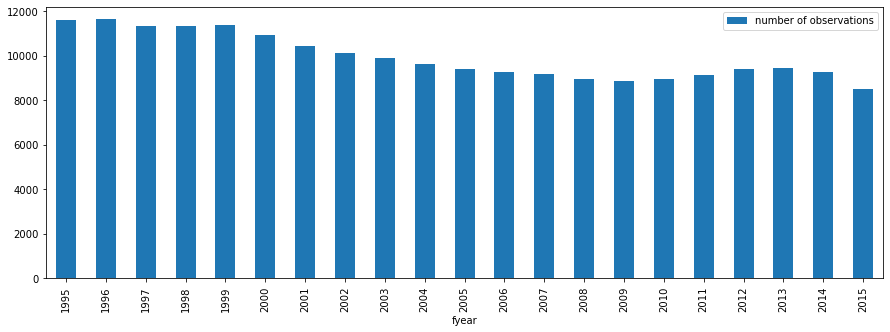

In [257]:
df_evolution = pd.DataFrame(pd.to_datetime(df_USA['fyear']).dt.year.value_counts()).reset_index().set_axis(['fyear','number of observations'], axis=1).sort_values(['fyear']).set_index(['fyear'])
df_evolution.plot.bar(figsize=(15,5))

[5 points] Winsorize each ratio at 1st and 99th percentile in each fiscal year. Create a table  
with summary statistics that contains: the mean, the median, the minimum, the maximum,  
the standard deviation and the number of non-missing observations for each of the financial  
ratios. Hint: to winsorize means to set values below (or above) a certain quantile to the value  
of that quantile in the data; each ratio will typically have a different number of non-missing  
observations.

In [266]:
df_USA = df_USA.reset_index().set_index(['fyear'])
df_ratio = df_USA[ratios_info]
test=df_ratio.sort_index().reset_index()

In [268]:
import numpy as np
from scipy.stats.mstats import winsorize

test.replace([np.inf, -np.inf], np.nan, inplace=True)
array_ratio = np.array(test[ratios])
winso_data = pd.DataFrame(winsorize(array_ratio,(0.01,0.01),nan_policy = 'omit'))
#We have to windsorise by year, and not by raito, so loop?
#test = test.groupby(['Book_leverage1', pd.Grouper(key='fyear',freq='Y')],as_index=False).last()
#df_ratio['Book_leverage1_wins'] = df['Book_leverage1'].clip(upper=df_ratio.groupby(pd.Grouper(freq='Y', key='datadate'))['Book_leverage1'].transform('quantile', 0.99), lower=df_ratio.groupby(pd.Grouper(freq='Y', key='datadate'))['Book_leverage1'].transform('quantile', 0.01))

winso_data['fyear'] = test['fyear']
winso_data.insert(0,'conm',test['conm'])
winso_data.set_index(['fyear'],inplace = True)
winso_data.set_axis(ratios_info, axis=1, inplace=True)
winso_data

,conm,Book_leverage1,Book_leverage2,Market_value_of_equity,Market_leverage,Market_to_book,Asset_growth,Asset_tangibility,Return_on_equity,Profit_margin,CAPEX_ratio,Dividend_yield,Dividend_payout_ratio,Total_payout_ratio,EBIT_interest_coverage,Cash_holdings,Profitability
fyear,,,,,,,,,,,,,,,,,
1995-01-01,MATEON THERAPEUTICS INC -OLD,0.000000,0.059678,72.494375,0.000000,6.457146,NaN,0.003296,-0.352183,NaN,0.002405,NaN,-0.000000,NaN,NaN,0.971675,-0.367418
1995-01-01,KAISER GROUP HOLDINGS INC,0.338693,0.862396,90.372000,0.531860,0.638707,0.313035,0.025817,0.079220,0.005327,0.004760,0.346118,0.653197,0.767318,1.047303,0.044266,0.060184
1995-01-01,KAISER ALUMINUM CORP,0.269480,0.935874,940.261875,0.446266,NaN,NaN,0.394426,1.052356,0.026946,0.028224,NaN,0.344942,0.344942,2.177870,0.007785,0.108382
1995-01-01,KAISER ALUMINUM & CHEMICAL,0.276232,0.941620,NaN,NaN,NaN,NaN,0.394272,1.569712,0.029180,0.028213,NaN,0.010720,0.145482,2.183040,0.007711,0.108517
1995-01-01,KAHLER REALTY CORP,0.762215,0.864476,51.516000,0.725204,1.051035,NaN,0.877875,0.124809,0.024879,0.081517,NaN,0.196884,0.196884,1.237889,0.005175,0.140088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-01-01,ILLINOIS TOOL WORKS,0.471867,0.667620,33711.052480,0.180439,2.598834,-0.110250,0.100261,0.363515,0.141664,0.018056,7.835269,0.390732,1.444971,12.694690,0.196452,0.212601
2015-01-01,SPDR S&P REGIONAL BKG ETF,NaN,NaN,2779.960320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01,APPLIED ENERGETICS INC,0.000000,0.401460,0.357965,0.000000,5.094638,-0.676887,0.000000,-2.731707,NaN,0.000000,0.000000,-0.000000,-0.258929,NaN,1.000000,-1.642336


In [269]:
Table = pd.DataFrame(index = ratios, columns = ['Mean', 'Median', 'Minimum', 'Maximum', 'Standard Deviation', 'Number Missing Observations'])

mean = []
median = []
min = []
max = []
std_dev = []
nb_nan = []

for i in range(1,len(ratios_info)):
    mean.append(winso_data[winso_data.columns[i]].mean())
    median.append(winso_data[winso_data.columns[i]].median())
    min.append(winso_data[winso_data.columns[i]].min())
    max.append(winso_data[winso_data.columns[i]].max())
    std_dev.append(winso_data[winso_data.columns[i]].std())
    nb_nan.append(winso_data[winso_data.columns[i]].isna().sum())
    i+=1

Table['Mean'] = mean
Table['Median'] = median
Table['Minimum'] = min
Table['Maximum'] = max    
Table['Standard Deviation'] = std_dev
Table['Number Missing Observations'] = nb_nan
Table

,Mean,Median,Minimum,Maximum,Standard Deviation,Number Missing Observations
Book_leverage1,1.067248,0.176359,-0.050045,5.319000e+03,30.644540,31379
Book_leverage2,3.245000,0.644429,0.000000,2.596897e+04,105.290387,29945
Market_value_of_equity,2051.081176,132.017000,0.000000,1.819782e+06,13146.544679,49834
Market_leverage,0.254888,0.172303,-0.048001,1.694105e+00,0.262998,72857
Market_to_book,34.384099,1.255295,-0.793218,3.593750e+05,1727.756996,92517
Asset_growth,7.974330,0.022845,-1.000000,4.273970e+05,1204.038397,46672
Asset_tangibility,0.203756,0.093014,0.000000,1.666667e+00,0.246516,34984
Return_on_equity,0.671362,0.080015,-6.449316,7.770333e+03,32.234609,52981
Profit_margin,-0.220929,0.028887,-6.449316,5.617383e+03,20.748490,60041
CAPEX_ratio,0.058360,0.027464,-2.771739,3.410000e+02,0.968346,62500


3. [5 points] Split the firms into 4 groups (quartiles) each year depending on the market value  
of equity. Create a table with summary statistics of ALL variables in Table 1 for the firms  
in the smallest and largest quartiles that contains the mean, the median and the standard  
deviation for each of the two subsamples. Comment on the main differences between the two  
samples and provide a reason why this may be the case.